In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import os
import sys

In [35]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [36]:
train

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units
0,202119-6909,2021-05-15,202119,6909,93,Arale,21274,13.3,Premium,2.0,35.0
1,202120-6909,2021-05-22,202120,6909,93,Arale,21274,13.3,Premium,0.0,70.0
2,202121-6909,2021-05-29,202121,6909,93,Arale,21274,13.3,Premium,3.0,137.0
3,202122-6909,2021-06-05,202122,6909,93,Arale,21274,13.3,Premium,0.0,274.0
4,202123-6909,2021-06-12,202123,6909,93,Arale,21274,13.3,Premium,0.0,333.0
...,...,...,...,...,...,...,...,...,...,...,...
15449,202317-247737,2023-04-29,202317,247737,15,Arale,10637,13.3,Premium,0.0,62.0
15450,202317-247737,2023-04-29,202317,247737,24,Arale,10637,13.3,Premium,0.0,3.0
15451,202318-247737,2023-05-06,202318,247737,3,Arale,10637,13.3,Premium,22.0,0.0
15452,202318-247737,2023-05-06,202318,247737,15,Arale,10637,13.3,Premium,68.0,78.0


In [37]:
train.columns

Index(['id', 'date', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'specs', 'display_size', 'segment', 'sales_units',
       'inventory_units'],
      dtype='object')

In [38]:
# Convert "date" column to datetime

train['date'] = pd.to_datetime(train['date'])

In [39]:
# Group by "id" and calculate total sales of column "sales_units"

sales = train.groupby('product_number').agg({'sales_units': 'sum'})

# Set index to "id" column

sales = sales.reset_index().sort_values(by='sales_units', ascending=False).set_index('product_number')

sales

,sales_units
product_number,
45402,10975.0
24675,10002.0
247737,8023.0
41454,7984.0
33558,7651.0
...,...
237867,1957.0
6909,1810.0
32571,1771.0


In [40]:
no_sales = sales[sales['sales_units'] == 0]

no_sales

,sales_units
product_number,


<Axes: xlabel='date'>

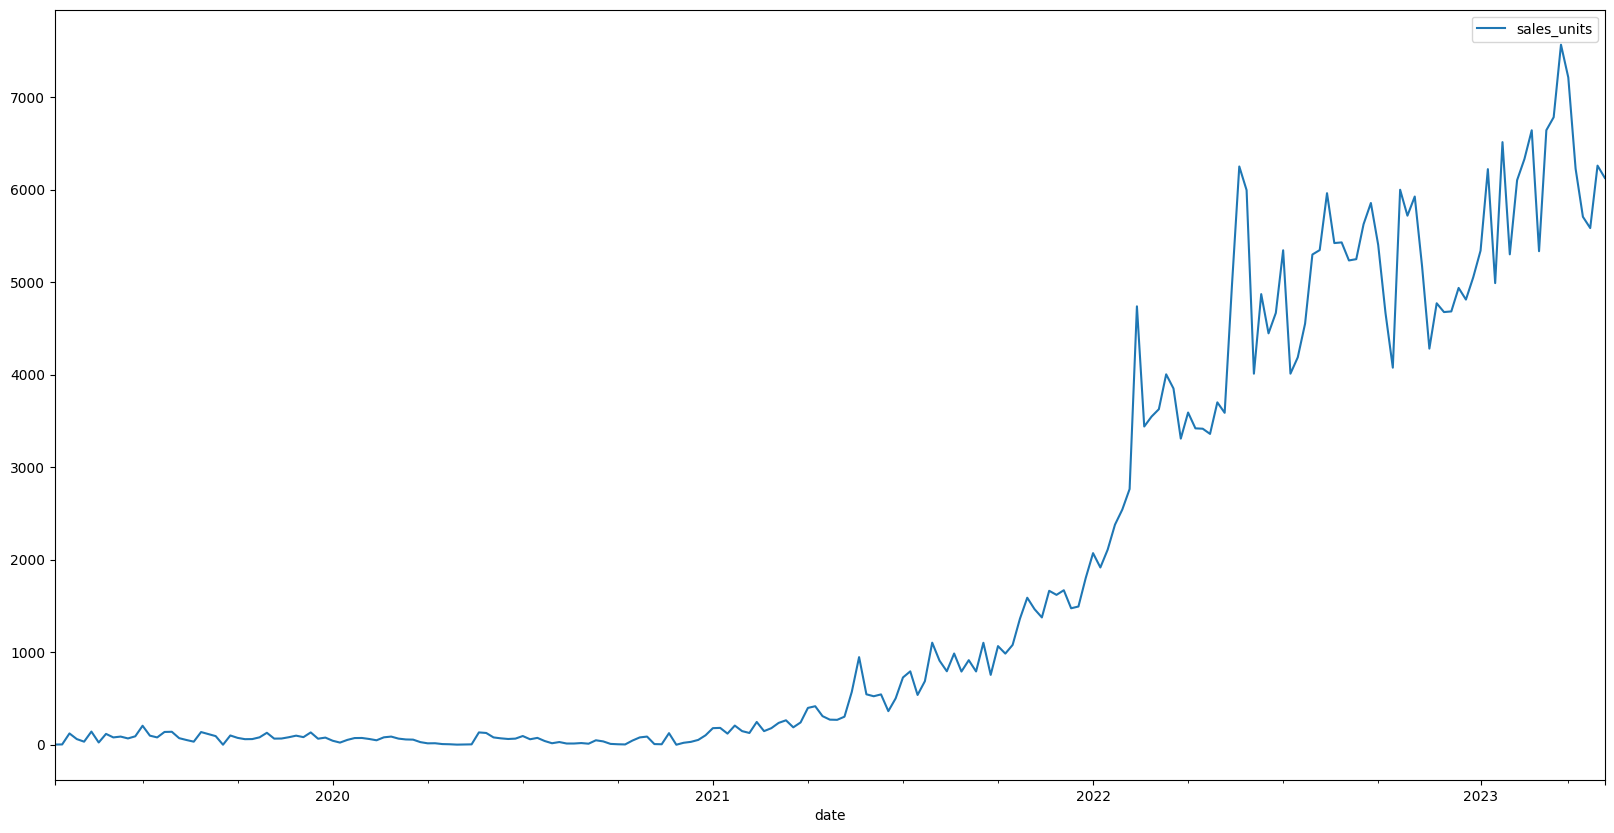

In [41]:
# Plot sales over time

sales = train.groupby('date').agg({'sales_units': 'sum'})

sales.plot(figsize=(20, 10))

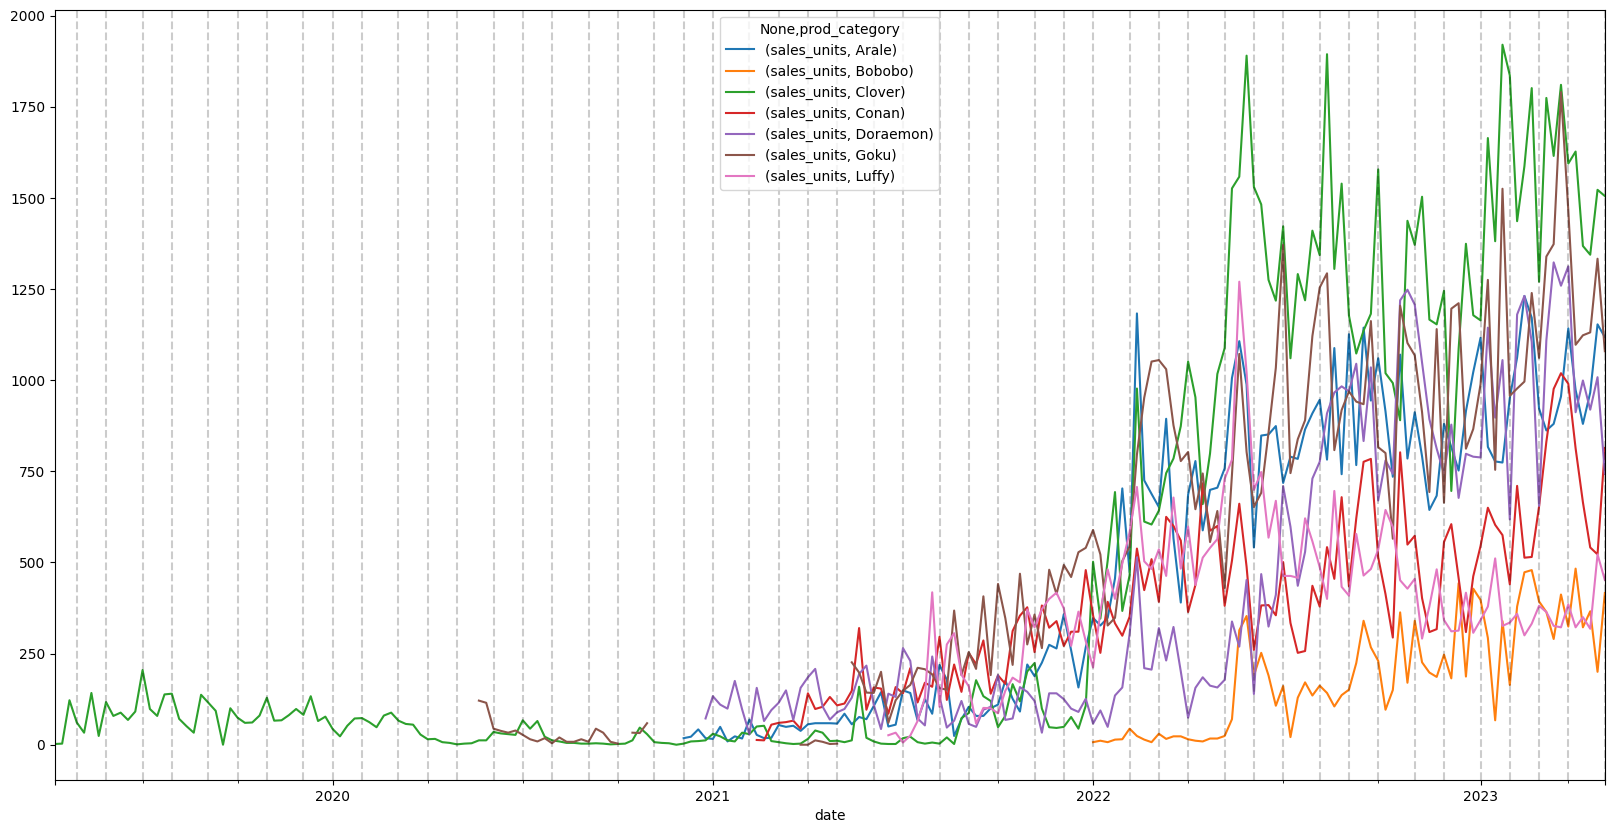

In [42]:
# Plot sales over time decomposed by prod_category

def plot_sales_by_prod(df, group_time=False, correct_days=False):
    # Group by "date" and "prod_category" and calculate total sales of column "sales_units" 

    df = df.copy()

    if group_time == 'month':
        
        # Map "date" column to year-month format

        df['date'] = df['date'].map(lambda x: x.strftime('%Y-%m'))

        # Convert "date" column to datetime

        df['date'] = pd.to_datetime(df['date'])
    sales = df.groupby(['date', 'prod_category']).agg({'sales_units': 'sum'})

    if group_time == 'month' and correct_days:
        # Correct the number of days in each month
        days_in_month = sales.index.get_level_values('date').daysinmonth
        sales['sales_units'] = sales['sales_units'] / days_in_month


    # Plot sales over time decomposed by prod_category

    sales.unstack().plot(figsize=(20, 10))

    # Plot vertical lines for each month

    for i in range(1, 13):
        for j in range(2018, 2024):
            plt.axvline(pd.to_datetime(f'{j}-{i}-01'), color='k', linestyle='--', alpha=0.2)


plot_sales_by_prod(train)
    

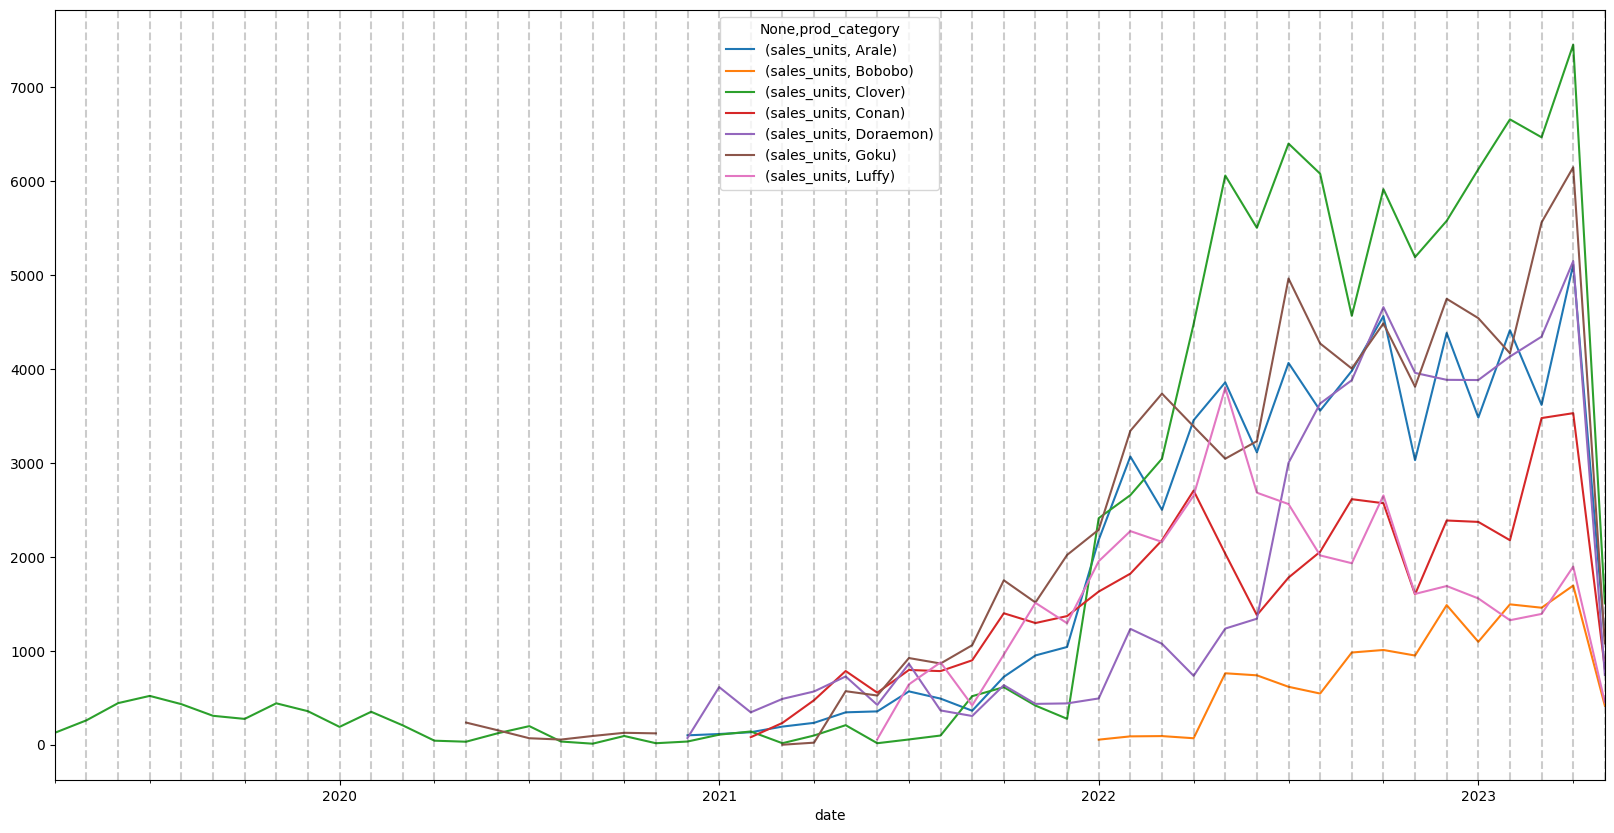

In [43]:
plot_sales_by_prod(train, group_time='month')

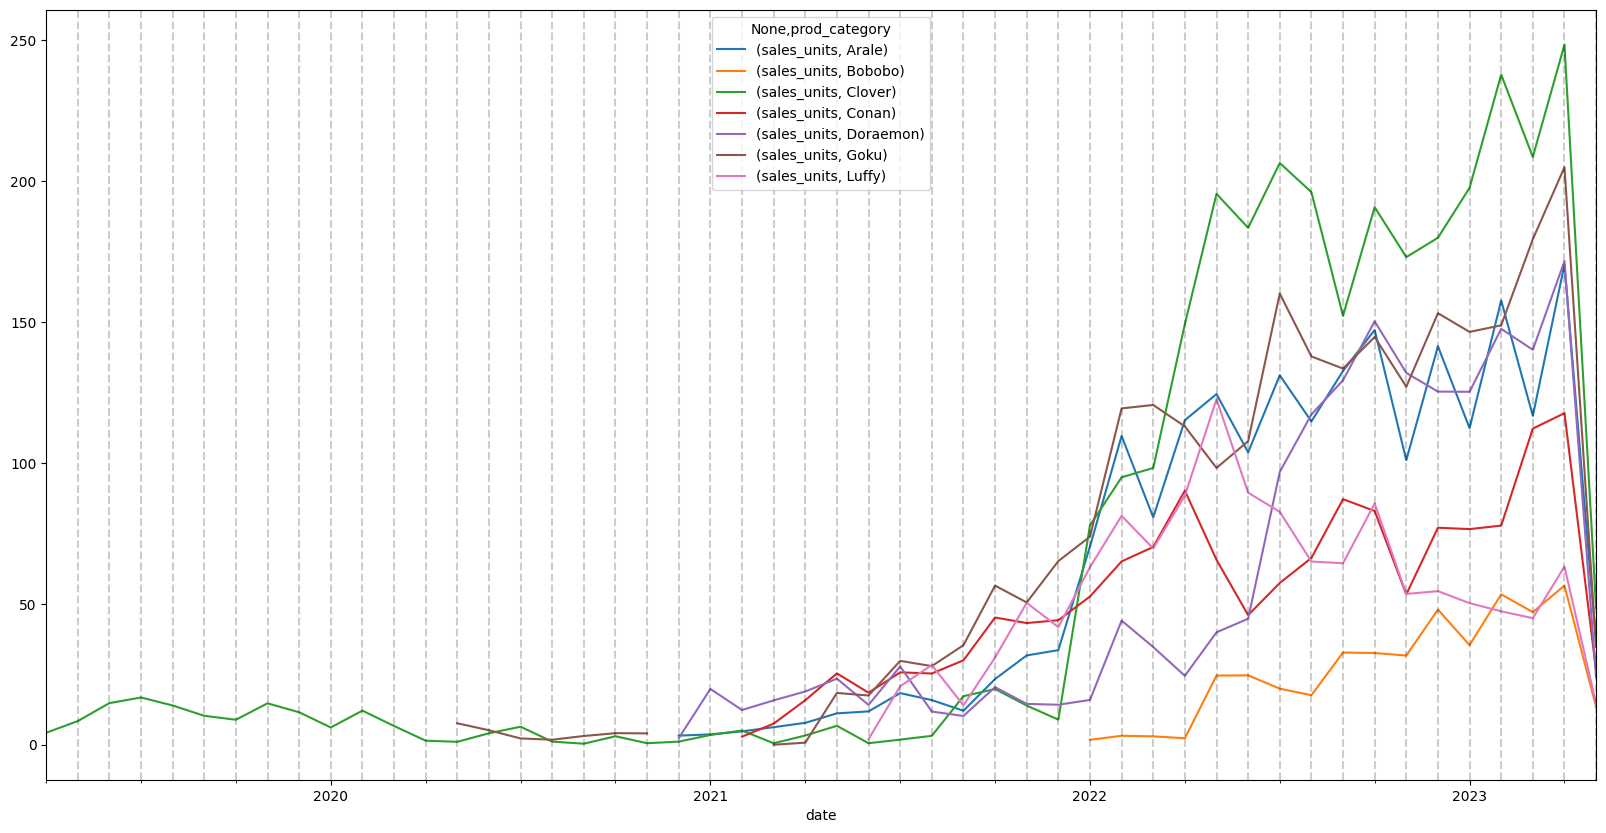

In [44]:
plot_sales_by_prod(train, group_time='month', correct_days=True)

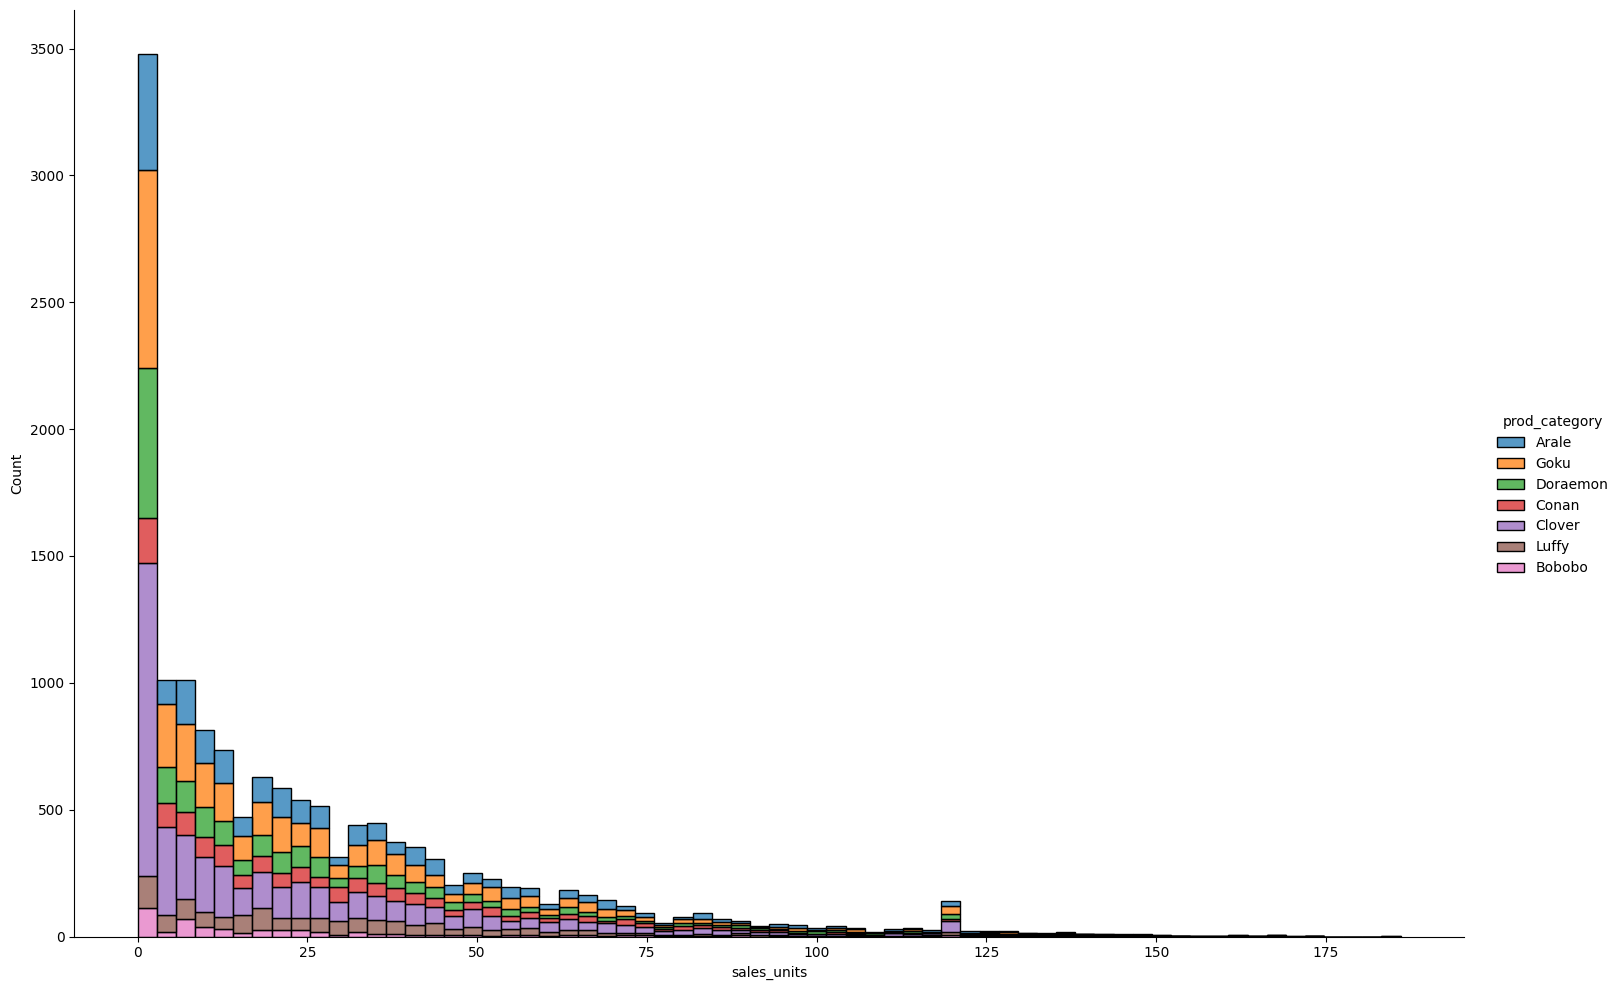

In [45]:
# For each prod_category plot the distribution of sales_units

def plot_sales_dist(df):
    # For each prod_category plot the distribution of sales_units

    sns.displot(df, x='sales_units', hue='prod_category', fill=True, height=10, aspect=1.5, multiple="stack")

plot_sales_dist(train)

In [46]:
# Does each product_number have a unique prod_category?

unique_cat = train.groupby('product_number')['prod_category'].nunique()

unique_cat[unique_cat > 1] # Yes, only one category

Series([], Name: prod_category, dtype: int64)

In [47]:
# Get the number of products in each prod_category

train.groupby('prod_category').agg({'product_number': 'nunique'})

,product_number
prod_category,
Arale,15
Bobobo,4
Clover,28
Conan,8
Doraemon,15
Goku,22
Luffy,8


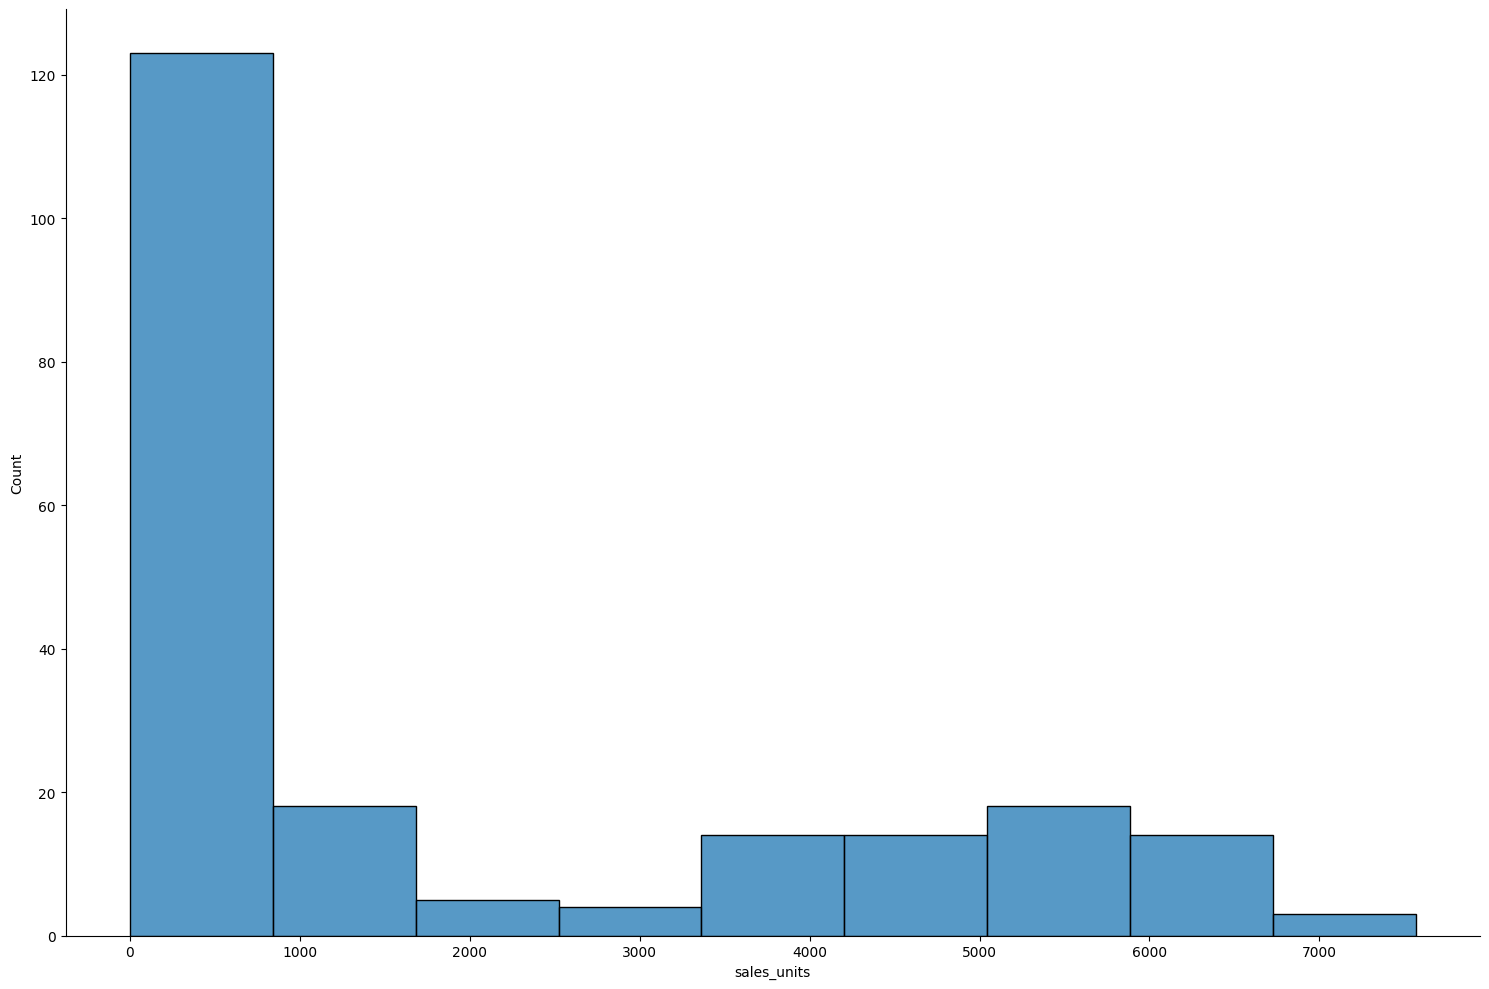

In [48]:
# Plot distribution of sales_units for any given day

def plot_sales_dist_by_date(df):
    # Plot distribution of sales_units

    # Group by "date" and calculate total sales of column "sales_units"

    sales = df.groupby('date').agg({'sales_units': 'sum'})

    # Plot distribution of sales_units for any given day

    sns.displot(sales, x='sales_units', fill=True, height=10, aspect=1.5)

plot_sales_dist_by_date(train)


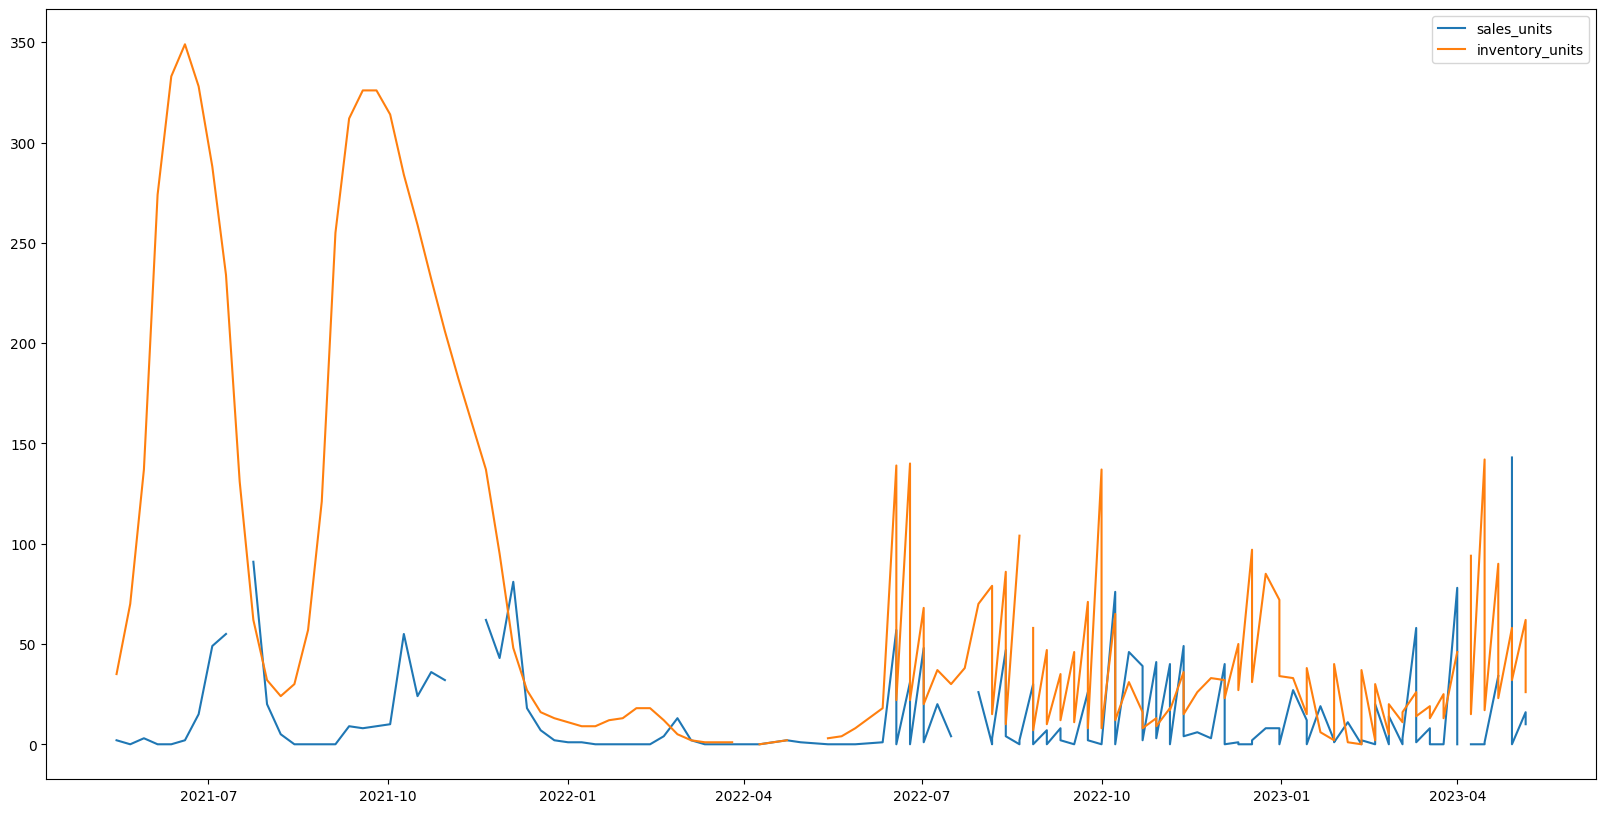

In [49]:

# For each different product_id plot the sales_units and the inventory_units over time

def plot_sales_and_inventory(df, product_id):

    # Filter by "product_id"

    df = df[df['product_number'] == product_id]

    # Plot sales_units and inventory_units over time

    fig, ax = plt.subplots(figsize=(20, 10))

    ax.plot(df['date'], df['sales_units'], label='sales_units')

    ax.plot(df['date'], df['inventory_units'], label='inventory_units')

    ax.legend()

    plt.show()


plot_sales_and_inventory(train, 6909)

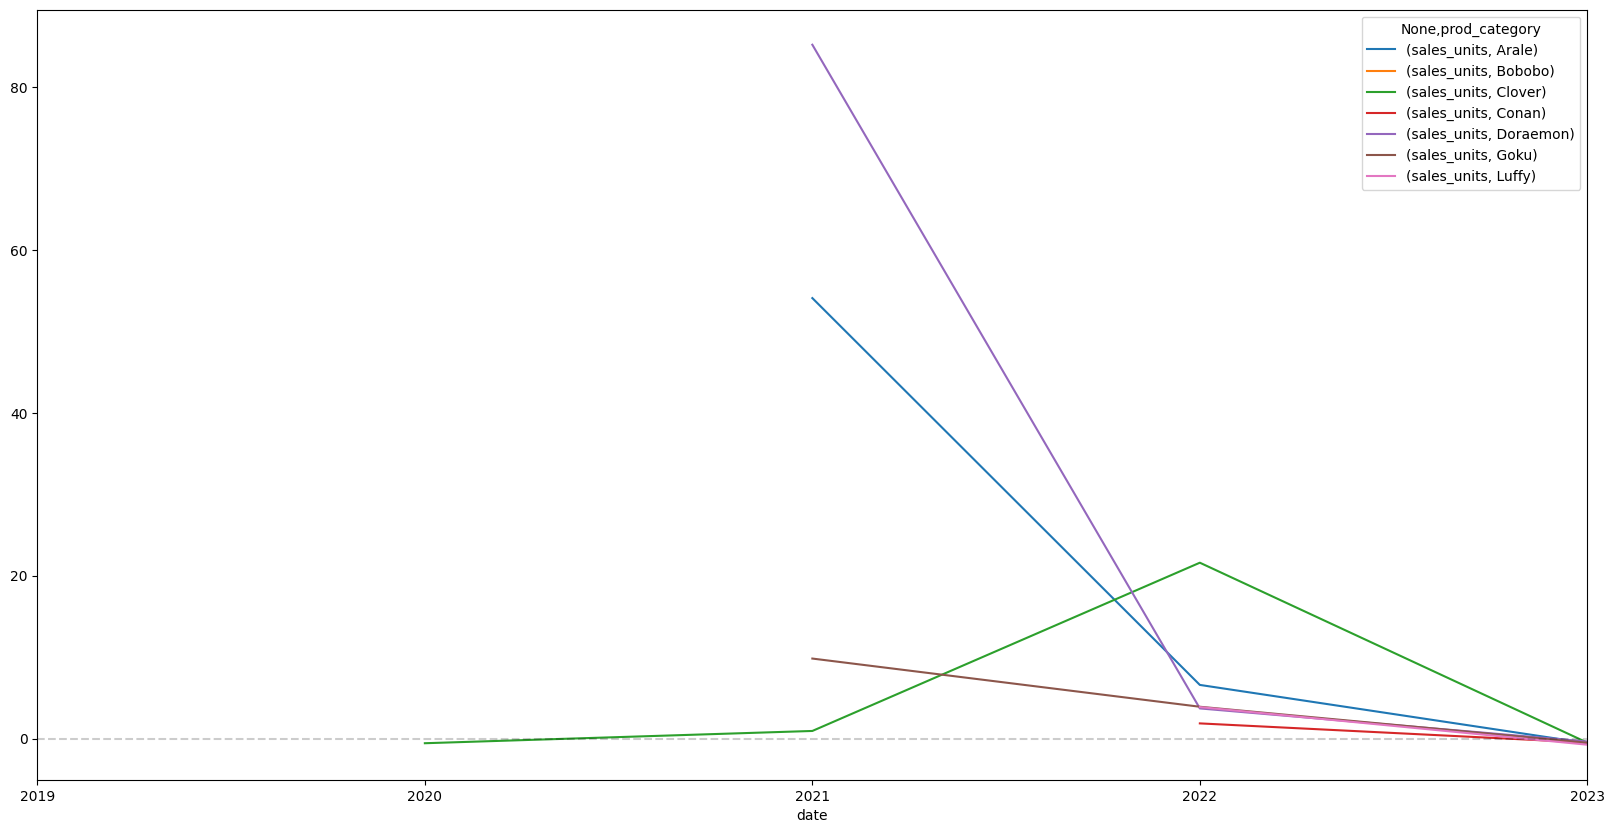

In [50]:
# Plot Y/Y growth of sales_units for each prod_category

def plot_sales_growth(df):
    # Plot Y/Y growth of sales_units for each prod_category

    # Group by "date" and "prod_category" and calculate total sales of column "sales_units" 

    df = df.copy()

    # Map "date" column to year format

    df['date'] = df['date'].map(lambda x: x.strftime('%Y'))

    # Convert "date" column to datetime

    df['date'] = pd.to_datetime(df['date'])

    sales = df.groupby(['date', 'prod_category']).agg({'sales_units': 'sum'})

    # Plot Y/Y growth of sales_units for each prod_category

    sales = sales.unstack()

    sales.pct_change().plot(figsize=(20, 10))

    plt.axhline(0, color='k', linestyle='--', alpha=0.2)

    plt.show()

plot_sales_growth(train)

In [51]:
def get_random_colors(num_colors):
    # Get random colors

    import matplotlib, random
    colors = dict(matplotlib.colors.cnames.items())
    hex_colors = tuple(colors.values())
    # print(hex_colors)
    #getting a random color from the dict
    # print(random.choice(hex_colors))

    return hex_colors

# We will now do a Sankey diagram 
# to see the flow of revenue
# There will be 3 columns:
# 1. general revenue (100%)
# 2. revenue from product_category
# 3. revenue from product_id

num_categories = train['prod_category'].nunique()
num_products = train['product_number'].nunique()

source = [0] * num_categories
target = [1 + i for i in range(num_categories)]
label = ['revenue']
color = ['blue']

sales_by_category = train.groupby('prod_category').agg({'sales_units': 'sum'})

sales_by_category = sales_by_category.reset_index().sort_values(by='sales_units', ascending=False)

value = sales_by_category['sales_units'].tolist()

categories_index = {
    category: index + 1
    for index, category in enumerate(sales_by_category['prod_category'])
}
label += sales_by_category['prod_category'].tolist()
source_counter = num_categories + 1
color = get_random_colors(len(label))
color_link = [
    color[i]
    for i in range(1, len(label))
]

for category in train['prod_category'].unique():
    sales_by_product = train[train['prod_category'] == category].groupby('product_number').agg({'sales_units': 'sum'})
    sales_by_product = sales_by_product.reset_index().sort_values(by='sales_units', ascending=False)
    value += sales_by_product['sales_units'].tolist()
    source += [categories_index[category]] * sales_by_product.shape[0]
    target += [source_counter + i for i in range(sales_by_product.shape[0])]
    source_counter += sales_by_product.shape[0]
    label += sales_by_product['product_number'].tolist()
    color_link += [color[categories_index[category]]] * sales_by_product.shape[0]
    # print(category, sales_by_product)
    # break

import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 25,
      thickness = 10,
      line = dict(color = "black", width = 0.5),
      label = label,
      color = color
    ),
    link = dict(
      source = source,
      target = target,
      value = value,
      color = color_link
  ))])

fig.update_layout(title_text="Revenue by product category and actual product", font_size=10)
fig.show()

In [52]:
# Get the number of reporterhq_id

train['reporterhq_id'].nunique()

20

In [53]:
# Get the display_sizes

train['display_size'].unique()

array([13.3, 14. , 15.6, 16.1, 13.5, 17.3, 11. ])

In [54]:
# Get the segments

train['segment'].unique()

array(['Premium', 'Core', 'Gaming'], dtype=object)

In [55]:
# Number of specs for each product

specs_product = train.groupby('product_number').agg({'specs': 'nunique'})

In [56]:
# Get the number of products with more than 1 spec

specs_product[specs_product['specs'] > 1]

# Each product has a single spec

,specs
product_number,


50.05459053561158


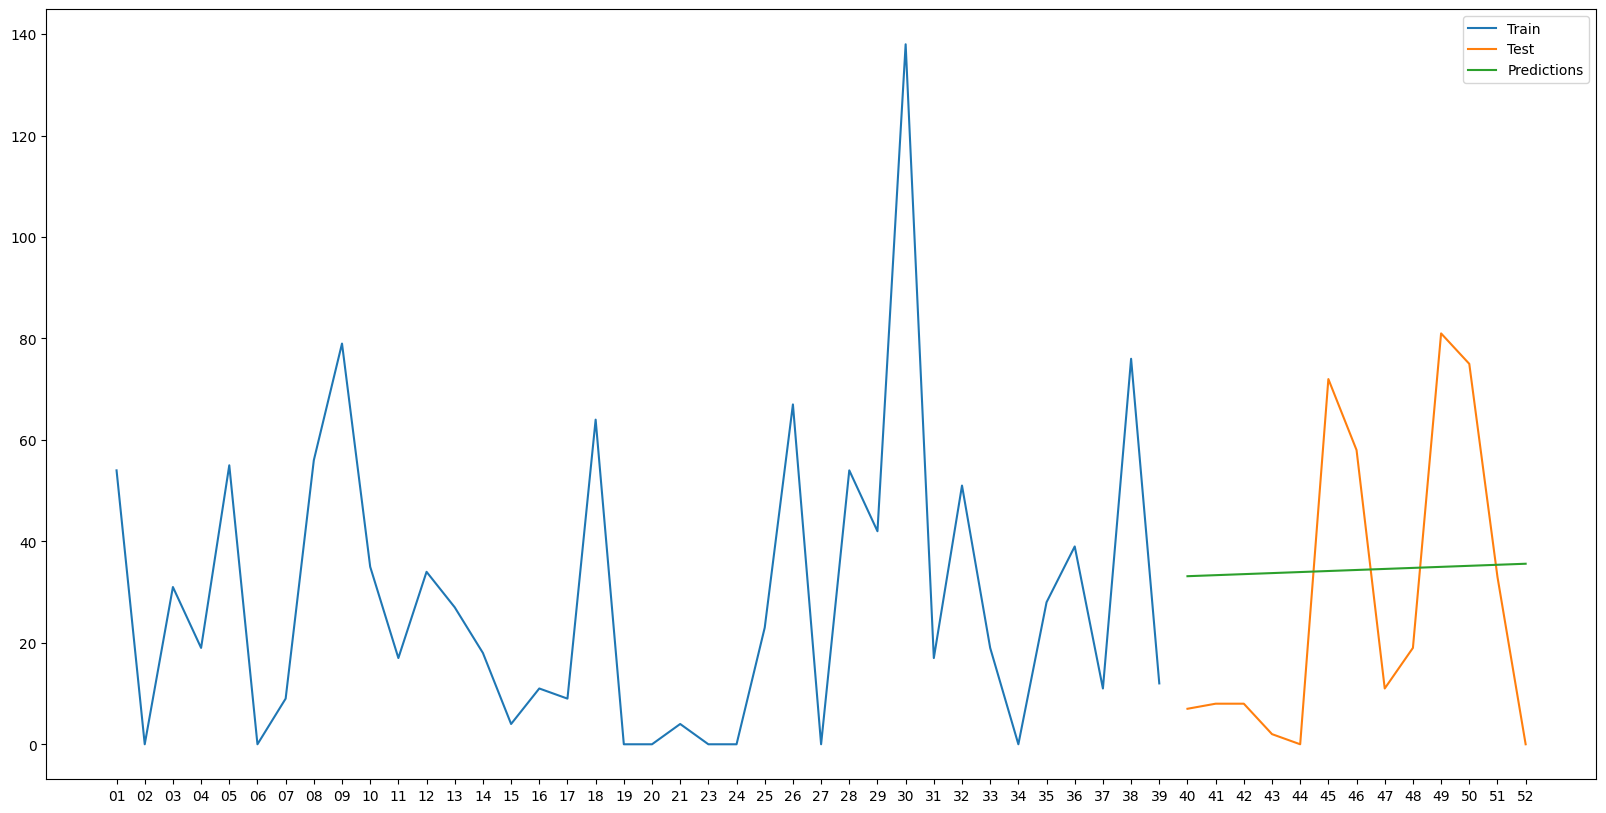

In [57]:
# Now let's make a prediction for the next
PREDICT_WEEKS = 13

# We will use a Linear Regression model

# For this first model we will use only the sales_units aggregated by week
# and then predict the next weeks by product_number

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

CONSIDER_FROM = '2022-03-01'

def get_train_test_data(df, product_number, predict_weeks):
    # Get train and test data

    # Filter by "product_number"

    df = df[(df['product_number'] == product_number) & (df['date'] >= CONSIDER_FROM)]
    df = df.copy()

    # Group by "date" and calculate total sales of column "sales_units"

    df['date'] = df['date'].map(lambda x: x.strftime('%W'))
    sales = df.groupby('date').agg({'sales_units': 'sum'})

    # Get train and test data

    train = sales[:-predict_weeks]
    test = sales[-predict_weeks:]

    return train, test

def get_X_y(train, test):
    # Get X and y

    X_train = train.index.astype(int).values.reshape(-1, 1)
    y_train = train['sales_units'].values

    X_test = test.index.astype(int).values.reshape(-1, 1)
    y_test = test['sales_units'].values

    return X_train, y_train, X_test, y_test

def get_model(X_train, y_train):
    # Get model

    model = LinearRegression()
    model.fit(X_train, y_train)

    return model

def get_predictions(model, X_test):
    # Get predictions

    predictions = model.predict(X_test)

    return predictions

def get_rmse(y_test, predictions):
    # Get RMSE

    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    return rmse

def plot_predictions(train, test, predictions):
    # Plot predictions

    plt.figure(figsize=(20, 10))

    plt.plot(train.index, train['sales_units'], label='Train')
    plt.plot(test.index, test['sales_units'], label='Test')
    plt.plot(test.index, predictions, label='Predictions')

    plt.legend()

    plt.show()

def get_predictions_by_product(df, predict_weeks):
    # Get predictions by product

    # Get unique products

    products = df['product_number'].unique()

    # Get predictions by product

    predictions_by_product = {}

    for product in products:
        # Get train and test data

        train, test = get_train_test_data(df, product, predict_weeks)

        # Get X and y

        X_train, y_train, X_test, y_test = get_X_y(train, test)

        # Get model

        model = get_model(X_train, y_train)

        # Get predictions

        predictions = get_predictions(model, X_test)

        # Get RMSE

        rmse = get_rmse(y_test, predictions)

        # Plot predictions

        # plot_predictions(train, test, predictions)

        # Save predictions

        predictions_by_product[product] = {
            'train': train,
            'test': test,
            'predictions': predictions,
            'rmse': rmse
        }

    return predictions_by_product

predictions_by_product = get_predictions_by_product(train, PREDICT_WEEKS)

# Plot predictions

def plot_predictions_by_product(predictions_by_product):
    # Plot predictions by product

    for product, data in predictions_by_product.items():
        # Get train and test data

        train = data['train']
        test = data['test']
        predictions = data['predictions']

        # Plot predictions

        plot_predictions(train, test, predictions)

# plot_predictions_by_product(predictions_by_product)

# Get Average RMSE

def get_average_rmse(predictions_by_product):
    # Get Average RMSE

    rmse = []

    for product, data in predictions_by_product.items():
        rmse.append(data['rmse'])

    return np.mean(rmse)

print(get_average_rmse(predictions_by_product))

# Plot predictions by product of a random product

def plot_predictions_by_product_random(predictions_by_product):
    # Plot predictions by product of a random product

    # Get random product

    product = np.random.choice(list(predictions_by_product.keys()))

    # Get train and test data

    train = predictions_by_product[product]['train']
    test = predictions_by_product[product]['test']
    predictions = predictions_by_product[product]['predictions']

    # Plot predictions

    plot_predictions(train, test, predictions)

plot_predictions_by_product_random(predictions_by_product)

# Okay, we now have a pretty simple but reliable Linear Regresssion Model
# Now starts the fun stuff. Let's try to take into account autocorrelation, seasonality etc.

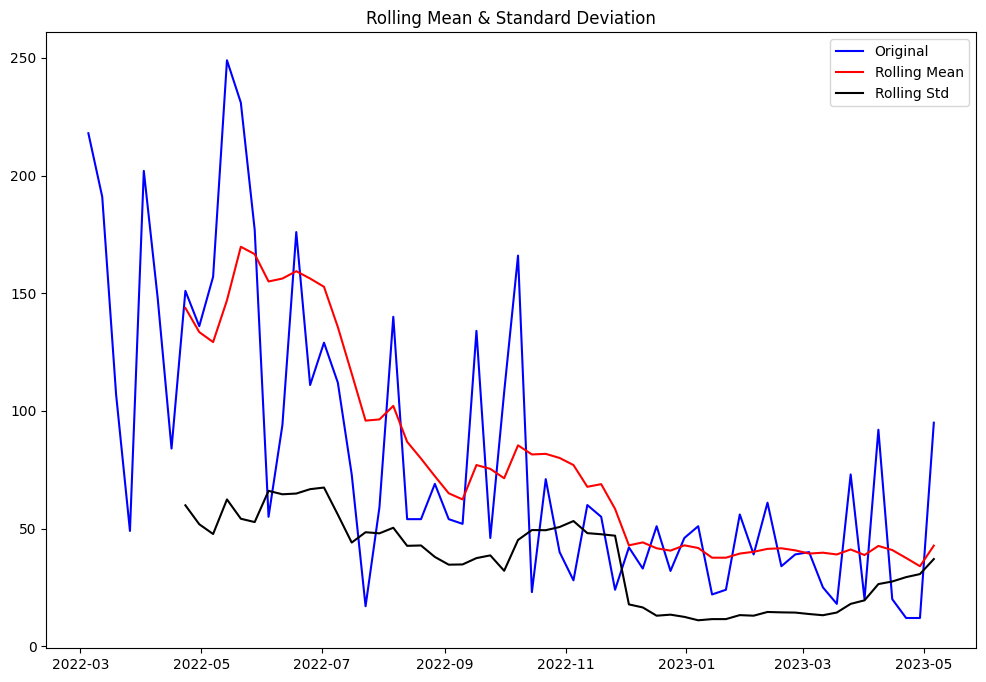

Results of Dickey-Fuller Test:
Test Statistic                 -1.375048
p-value                         0.594178
#Lags Used                      8.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


In [58]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window=8):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


station_test = train[(train['product_number'] == 247737) & (train['date'] >= CONSIDER_FROM)]
station_test = station_test.groupby('date').agg({'sales_units': 'sum'})

test_stationarity(station_test['sales_units'])
# test_stationarity(train, 6909)

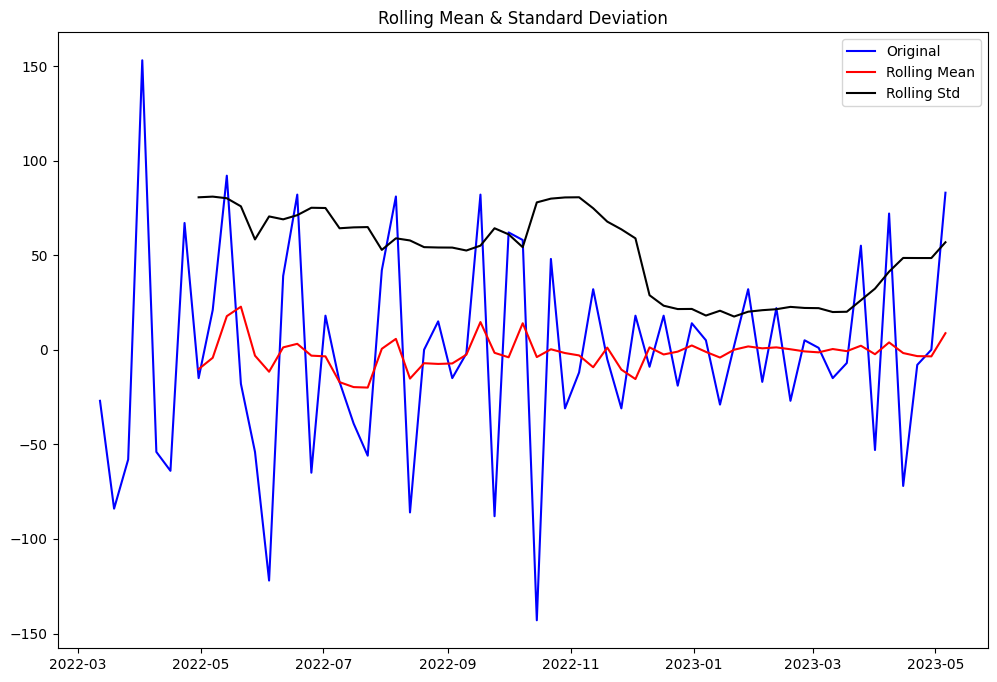

Results of Dickey-Fuller Test:
Test Statistic                -5.913094e+00
p-value                        2.610780e-07
#Lags Used                     4.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64


In [59]:

train_prepared = train.copy()

# TODO: Fill NaNs

train_prepared = train_prepared[(train_prepared['product_number'] == 247737) & (train_prepared['date'] >= CONSIDER_FROM)]
train_prepared = train_prepared.groupby('date').agg({'sales_units': 'sum'})['sales_units']

train_prepared['first_difference'] = train_prepared - train_prepared.shift(1)
test_stationarity(train_prepared['first_difference'].dropna(inplace=False))

timeseries = train_prepared['first_difference']



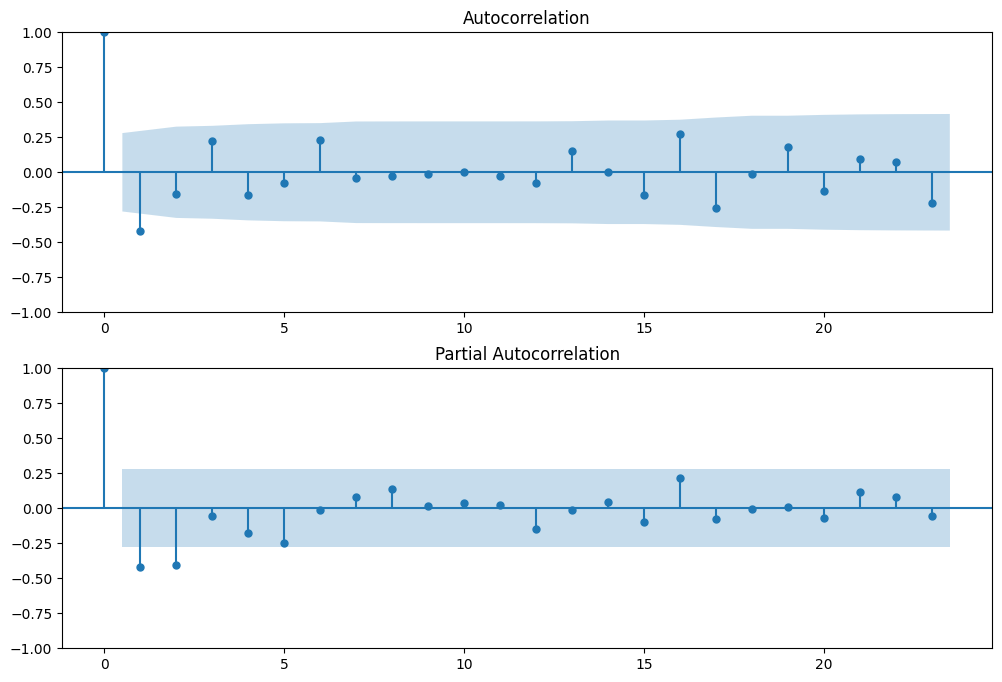

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

LOOKBACK = 13

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(timeseries.iloc[LOOKBACK:], lags=23, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(timeseries.iloc[LOOKBACK:], lags=23, ax=ax2)

In [80]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(station_test['sales_units'], trend='n', order=(1,1,1), seasonal_order=(1,1,1,10))
results = mod.fit()
print(results.summary())

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.

/home/josalhor/Desktop/hp_pred/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.



                                    SARIMAX Results                                     
Dep. Variable:                      sales_units   No. Observations:                   62
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 10)   Log Likelihood                -274.242
Date:                          Sat, 13 May 2023   AIC                            558.484
Time:                                  12:54:22   BIC                            568.143
Sample:                              03-05-2022   HQIC                           562.175
                                   - 05-06-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1560      0.186      0.840      0.401      -0.208       0.520
ma.L1         -0.8853      0.144     -6.131      0.

            sales_units  forecast
date                             
2022-03-05        218.0       NaN
2022-03-12        191.0       NaN
2022-03-19        107.0       NaN
2022-03-26         49.0       NaN
2022-04-02        202.0       NaN
...                 ...       ...
2023-04-08         92.0       NaN
2023-04-15         20.0       NaN
2023-04-22         12.0       NaN
2023-04-29         12.0       NaN
2023-05-06         95.0       NaN

[62 rows x 2 columns]


<Axes: xlabel='date'>

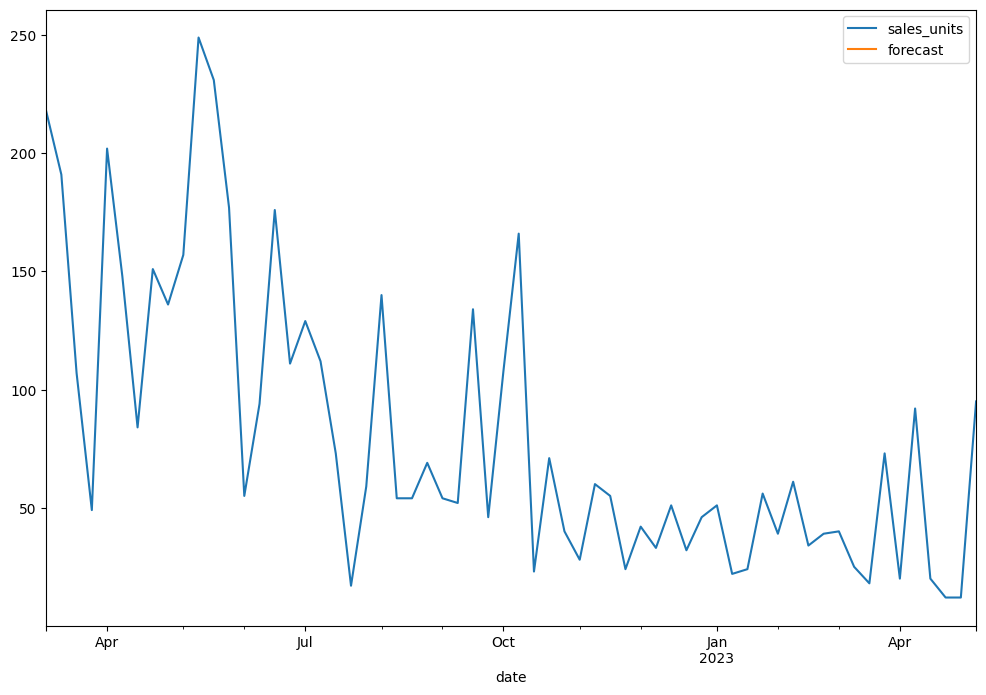

In [95]:


prediction = results.predict(start = 62, end= 62+13, dynamic= True)

# Append predictions to test data as forecast column in new rows
# We cannot directly assign to test['forecast'] because the length of the forecast is different from the length of the test data

print(station_test)
station_test[['sales_units', 'forecast']].plot(figsize=(12, 8))